In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR


In [2]:
# Define the base directory
base_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']


In [3]:
# Find all metadata files in the base directory
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))


Found Metadata Files:
COVID.metadata.xlsx
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
Viral Pneumonia.metadata.xlsx


In [4]:
# Define paths
root_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Load metadata
metadata = {}
for cls in classes:
    metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx' if cls != 'Viral Pneumonia' else 'Viral Pneumonia.metadata.xlsx')
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")

Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [5]:
# Inspect columns for each metadata DataFrame
for cls in classes:
    if cls in metadata:
        print(f"\nColumns in {cls} Metadata:")
        print(metadata[cls].columns)



Columns in COVID Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Lung_Opacity Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Normal Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Viral Pneumonia Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


In [6]:
class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        """
        Args:
            image_label_pairs (list of tuples): List where each tuple contains (image_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
#         print(f"Loading image from: {image_path}")
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Print the size of the image to check channels
#         print(f"Image size: {image.size}, Image mode: {image.mode}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [7]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Define the root directory of the dataset
root_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"

# Define class names
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# Map images to labels
label_mapping = {cls: idx for idx, cls in enumerate(classes)}
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to their labels
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        
        # Append the image path and label to the mapped data list
        all_mapped_data.append((img_path, label_mapping[cls]))

# Optionally, print the mapped data
print(f"Total Mapped Data: {len(all_mapped_data)}")
for img_path, label in all_mapped_data[:10]:  # Only print the first 10 items to avoid large output
    print(f"Image Path: {img_path}, Label: {label}")


# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")

Total Mapped Data: 21165
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-10.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-100.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1000.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1001.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1002.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID

,image_path,label
0,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
1,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
2,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
3,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
4,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0


Total images mapped: 21165


In [9]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")

Total samples: 21165
Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [10]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[1] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[1] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [11]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
# Compute class weights
train_labels = [sample[1] for sample in train_data]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Class Weights: tensor([1.4634, 0.8802, 0.5192, 3.9318])


In [12]:
# Create Dataset instances
train_dataset = COVID19RadiographyDataset(train_data, transform=train_transforms)
val_dataset = COVID19RadiographyDataset(val_data, transform=val_transforms)
test_dataset = COVID19RadiographyDataset(test_data, transform=val_transforms)

# Define batch size and number of workers
batch_size = 16
num_workers = 0 

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 926, Val: 133, Test: 265


In [13]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")


Train data size: 14815
Validation data size: 2116
Test data size: 4234


In [14]:
print(train_data[0])  # Should print something like: (image_path, label)
print(val_data[0])
print(test_data[0])


('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\COVID\\images\\COVID-278.png', 0)
('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\Normal\\images\\Normal-4150.png', 2)
('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\COVID\\images\\COVID-868.png', 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.907974].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8506721..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4500387..1.7511113].


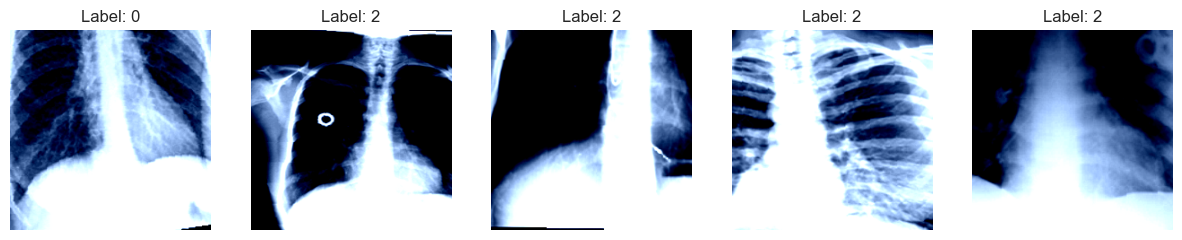

In [15]:
import matplotlib.pyplot as plt

# Check first batch
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx == 0:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            ax = axes[i]
            ax.imshow(images[i].permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
            ax.set_title(f"Label: {labels[i].item()}")
            ax.axis('off')
        plt.show()
        break  # Exit after the first batch


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19100\514221396.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=train_label_counts.values, palette='viridis', legend = 'False')


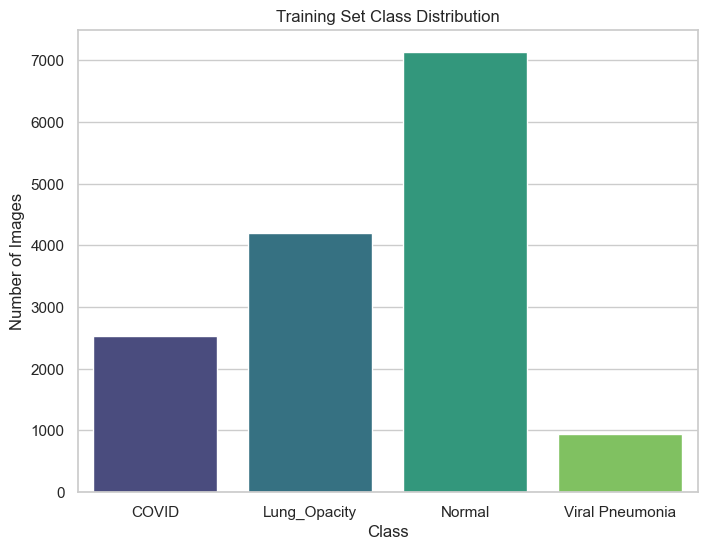

In [16]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis', legend = 'False')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [17]:
# import matplotlib.pyplot as plt

# def display_images_from_loader(loader, num_images=5):
#     data_iter = iter(loader)
#     images, labels = next(data_iter)

#     # Ensure num_images does not exceed batch size
#     num_images = min(num_images, images.size(0))  # Adjust if batch size is smaller

#     # Create a figure with subplots
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

#     for i in range(num_images):
#         ax = axes[i]
#         image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
#         ax.imshow(image)
#         ax.set_title(f"Label: {labels[i].item()}")
#         ax.axis('off')
#         print(f"Image {i+1} shape: {images[i].shape}")  # Print image shape to verify resize

#     plt.show()

# # Check train_loader
# print("Training images:")
# display_images_from_loader(train_loader)

# # Check val_loader
# print("Validation images:")
# display_images_from_loader(val_loader)

# # Check test_loader
# print("Testing images:")
# display_images_from_loader(test_loader)


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [19]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        
        # Load MobileNetV2 without ImageNet weights (pretrained=False)
        self.model = models.mobilenet_v2(pretrained=False)
        
        # Replace the classifier with the number of classes you need
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
    
    def forward(self, x):
        return self.model(x)

## ska block

In [21]:
class SKAttention(nn.Module):
    def __init__(self, channels, reduction=16, num_paths=2):
        super(SKAttention, self).__init__()
        self.num_paths = num_paths
        self.d = max(channels // reduction, 32)
        self.fc = nn.Sequential(
            nn.Linear(channels, self.d),
            nn.ReLU(inplace=True)
        )
        self.fcs = nn.ModuleList([nn.Linear(self.d, channels) for _ in range(num_paths)])
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        feats = [F.adaptive_avg_pool2d(x, 1) for _ in range(self.num_paths)]
        feats = torch.cat(feats, dim=1).view(batch_size, self.num_paths, channels)
        z = self.fc(feats.sum(dim=1))
        attention_weights = torch.stack([fc(z) for fc in self.fcs], dim=1)
        attention_weights = self.softmax(attention_weights)
        attention_weights = attention_weights.unsqueeze(-1).unsqueeze(-1)
        out = sum([w * f for w, f in zip(attention_weights.unbind(1), feats.unbind(1))])
        return out
    
class MobileNetV2WithSKA(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2WithSKA, self).__init__()
        self.mobilenet = models.mobilenet_v2(weights=None)
        bottleneck_channels = self.mobilenet.last_channel
        self.ska = SKAttention(channels=bottleneck_channels)
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(bottleneck_channels, num_classes)
        )

    def forward(self, x):
        x = self.mobilenet.features(x)
        x = self.ska(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.mobilenet.classifier(x)
        return x

In [22]:
class_counts = torch.tensor([723, 1203, 2039, 269])  # Replace with actual counts
class_weights = compute_class_weight('balanced', classes=np.arange(len(class_counts)), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to('cuda')

## model with attention block 

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model for binary or multi-class classification
num_classes = 4  # Modify based on your dataset (e.g., 2 for binary classification, 4 for multi-class)
model = MobileNetV2WithSKA(num_classes=num_classes)  # For RGB images

# Move the model to the GPU (or CPU if GPU is not available)
model.to(device)

# Check model architecture
print(model)

MobileNetV2WithSKA(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

In [25]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device='cuda'):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = None
    
    print(f"Using device: {device}")
    
    # Move model to the correct device
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                # Move data to the correct device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            
            # Check if this is the best model so far in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print(f"End of Epoch {epoch + 1}: Train Loss - {history['train_loss'][-1]:.4f}, "
              f"Val Loss - {history['val_loss'][-1]:.4f}")
    
    print(f'\nTraining complete. Best Validation Accuracy: {best_acc:.4f}')
    
    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, history

# Define number of epochs
num_epochs = 25

# Ensure you have set the device correctly (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming model, criterion, optimizer, scheduler, train_loader, and val_loader are defined properly

trained_model, history = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device=device
)


Using device: cuda
Using device: cuda

Epoch 1/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:13<00:00,  4.79it/s]


Train Loss: 1.3853, Accuracy: 0.3592


Val Phase: 100%|██████████| 133/133 [00:14<00:00,  9.40it/s]


Val Loss: 1.3835, Accuracy: 0.2840
End of Epoch 1: Train Loss - 1.3853, Val Loss - 1.3835

Epoch 2/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:11<00:00,  4.82it/s]


Train Loss: 1.3849, Accuracy: 0.3836


Val Phase: 100%|██████████| 133/133 [00:13<00:00,  9.53it/s]


Val Loss: 1.3964, Accuracy: 0.1711
End of Epoch 2: Train Loss - 1.3849, Val Loss - 1.3964

Epoch 3/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:03<00:00,  5.06it/s]


Train Loss: 1.3850, Accuracy: 0.3689


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.12it/s]


Val Loss: 1.3886, Accuracy: 0.4787
End of Epoch 3: Train Loss - 1.3850, Val Loss - 1.3886

Epoch 4/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:03<00:00,  5.05it/s]


Train Loss: 1.3842, Accuracy: 0.4149


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.20it/s]


Val Loss: 1.4129, Accuracy: 0.4816
End of Epoch 4: Train Loss - 1.3842, Val Loss - 1.4129

Epoch 5/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:04<00:00,  5.01it/s]


Train Loss: 1.3834, Accuracy: 0.3544


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.10it/s]


Val Loss: 1.4458, Accuracy: 0.4816
End of Epoch 5: Train Loss - 1.3834, Val Loss - 1.4458

Epoch 6/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:03<00:00,  5.04it/s]


Train Loss: 1.3846, Accuracy: 0.4130


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.16it/s]


Val Loss: 1.4187, Accuracy: 0.4816
End of Epoch 6: Train Loss - 1.3846, Val Loss - 1.4187

Epoch 7/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:03<00:00,  5.04it/s]


Train Loss: 1.3842, Accuracy: 0.3991


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.13it/s]


Val Loss: 1.3805, Accuracy: 0.3639
End of Epoch 7: Train Loss - 1.3842, Val Loss - 1.3805

Epoch 8/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:03<00:00,  5.03it/s]


Train Loss: 1.3839, Accuracy: 0.4232


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.24it/s]


Val Loss: 1.3799, Accuracy: 0.3927
End of Epoch 8: Train Loss - 1.3839, Val Loss - 1.3799

Epoch 9/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:06<00:00,  4.97it/s]


Train Loss: 1.3839, Accuracy: 0.4088


Val Phase: 100%|██████████| 133/133 [00:17<00:00,  7.65it/s]


Val Loss: 1.3801, Accuracy: 0.4509
End of Epoch 9: Train Loss - 1.3839, Val Loss - 1.3801

Epoch 10/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:30<00:00,  4.40it/s]


Train Loss: 1.3835, Accuracy: 0.4452


Val Phase: 100%|██████████| 133/133 [00:13<00:00,  9.66it/s]


Val Loss: 1.3827, Accuracy: 0.3318
End of Epoch 10: Train Loss - 1.3835, Val Loss - 1.3827

Epoch 11/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:09<00:00,  4.87it/s]


Train Loss: 1.3835, Accuracy: 0.4146


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s]


Val Loss: 1.3807, Accuracy: 0.4546
End of Epoch 11: Train Loss - 1.3835, Val Loss - 1.3807

Epoch 12/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:02<00:00,  5.06it/s]


Train Loss: 1.3835, Accuracy: 0.4418


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.10it/s]


Val Loss: 1.3796, Accuracy: 0.4608
End of Epoch 12: Train Loss - 1.3835, Val Loss - 1.3796

Epoch 13/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:03<00:00,  5.04it/s]


Train Loss: 1.3835, Accuracy: 0.4494


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.29it/s]


Val Loss: 1.3811, Accuracy: 0.3866
End of Epoch 13: Train Loss - 1.3835, Val Loss - 1.3811

Epoch 14/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:02<00:00,  5.07it/s]


Train Loss: 1.3834, Accuracy: 0.4420


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.23it/s]


Val Loss: 1.3811, Accuracy: 0.4145
End of Epoch 14: Train Loss - 1.3834, Val Loss - 1.3811

Epoch 15/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:09<00:00,  4.87it/s]


Train Loss: 1.3835, Accuracy: 0.4572


Val Phase: 100%|██████████| 133/133 [00:14<00:00,  9.45it/s]


Val Loss: 1.3808, Accuracy: 0.4026
End of Epoch 15: Train Loss - 1.3835, Val Loss - 1.3808

Epoch 16/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:12<00:00,  4.81it/s]


Train Loss: 1.3828, Accuracy: 0.4632


Val Phase: 100%|██████████| 133/133 [00:14<00:00,  9.38it/s]


Val Loss: 1.3800, Accuracy: 0.4532
End of Epoch 16: Train Loss - 1.3828, Val Loss - 1.3800

Epoch 17/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:12<00:00,  4.82it/s]


Train Loss: 1.3836, Accuracy: 0.4562


Val Phase: 100%|██████████| 133/133 [00:14<00:00,  9.44it/s]


Val Loss: 1.3829, Accuracy: 0.3455
End of Epoch 17: Train Loss - 1.3836, Val Loss - 1.3829

Epoch 18/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:15<00:00,  4.74it/s]


Train Loss: 1.3833, Accuracy: 0.4564


Val Phase: 100%|██████████| 133/133 [00:14<00:00,  9.31it/s]


Val Loss: 1.3802, Accuracy: 0.4461
End of Epoch 18: Train Loss - 1.3833, Val Loss - 1.3802

Epoch 19/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:12<00:00,  4.82it/s]


Train Loss: 1.3827, Accuracy: 0.4561


Val Phase: 100%|██████████| 133/133 [00:14<00:00,  9.33it/s]


Val Loss: 1.3816, Accuracy: 0.3974
End of Epoch 19: Train Loss - 1.3827, Val Loss - 1.3816

Epoch 20/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:07<00:00,  4.95it/s]


Train Loss: 1.3828, Accuracy: 0.4530


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.11it/s]


Val Loss: 1.3817, Accuracy: 0.3918
End of Epoch 20: Train Loss - 1.3828, Val Loss - 1.3817

Epoch 21/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:12<00:00,  4.81it/s]


Train Loss: 1.3832, Accuracy: 0.4595


Val Phase: 100%|██████████| 133/133 [00:14<00:00,  9.35it/s]


Val Loss: 1.3805, Accuracy: 0.4357
End of Epoch 21: Train Loss - 1.3832, Val Loss - 1.3805

Epoch 22/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:11<00:00,  4.83it/s]


Train Loss: 1.3828, Accuracy: 0.4655


Val Phase: 100%|██████████| 133/133 [00:13<00:00,  9.86it/s]


Val Loss: 1.3803, Accuracy: 0.4551
End of Epoch 22: Train Loss - 1.3828, Val Loss - 1.3803

Epoch 23/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:06<00:00,  4.97it/s]


Train Loss: 1.3833, Accuracy: 0.4589


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.07it/s]


Val Loss: 1.3799, Accuracy: 0.4570
End of Epoch 23: Train Loss - 1.3833, Val Loss - 1.3799

Epoch 24/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:04<00:00,  5.02it/s]


Train Loss: 1.3834, Accuracy: 0.4441


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.12it/s]


Val Loss: 1.3803, Accuracy: 0.4660
End of Epoch 24: Train Loss - 1.3834, Val Loss - 1.3803

Epoch 25/25
------------------------------


Train Phase: 100%|██████████| 926/926 [03:04<00:00,  5.01it/s]


Train Loss: 1.3830, Accuracy: 0.4508


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.06it/s]

Val Loss: 1.3803, Accuracy: 0.4816
End of Epoch 25: Train Loss - 1.3830, Val Loss - 1.3803

Training complete. Best Validation Accuracy: 0.4816


In [63]:
# from sklearn.metrics import classification_report, confusion_matrix
# def evaluate_model(model, dataloader, classes):
#     model.eval()
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for inputs, labels in tqdm(dataloader, desc='Testing'):
#             inputs = inputs.to(device)
#             labels = labels.to(device)
            
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
            
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
    
#     # Classification Report
#     print("Classification Report:")
#     print(classification_report(all_labels, all_preds, target_names=classes))
    
#     # Confusion Matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(10,8))
#     sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def evaluate_model(model, dataloader, classes):
    """
    Evaluate the model and generate a classification report and confusion matrix.

    Args:
        model: The trained PyTorch model.
        dataloader: DataLoader for the test set.
        classes: List of class names.
        device: Device to perform computations on (CPU/GPU).
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Check if all classes are predicted
    predicted_classes = set(all_preds)
    missing_classes = set(range(len(classes))) - predicted_classes
    if missing_classes:
        print(f"Warning: The following classes were not predicted: {missing_classes}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=classes,
        zero_division=0
    ))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=classes,
        yticklabels=classes,
        cmap='Blues'
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Testing: 100%|██████████| 265/265 [00:26<00:00,  9.89it/s]



Classification Report:
                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00       723
   Lung_Opacity       0.00      0.00      0.00      1203
         Normal       0.48      1.00      0.65      2039
Viral Pneumonia       0.00      0.00      0.00       269

       accuracy                           0.48      4234
      macro avg       0.12      0.25      0.16      4234
   weighted avg       0.23      0.48      0.31      4234



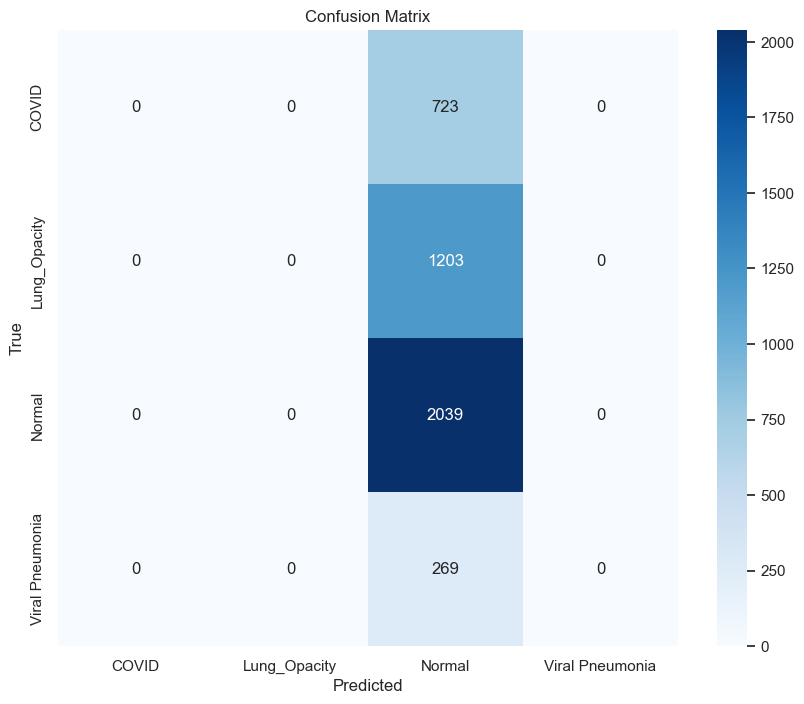

In [65]:
# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)

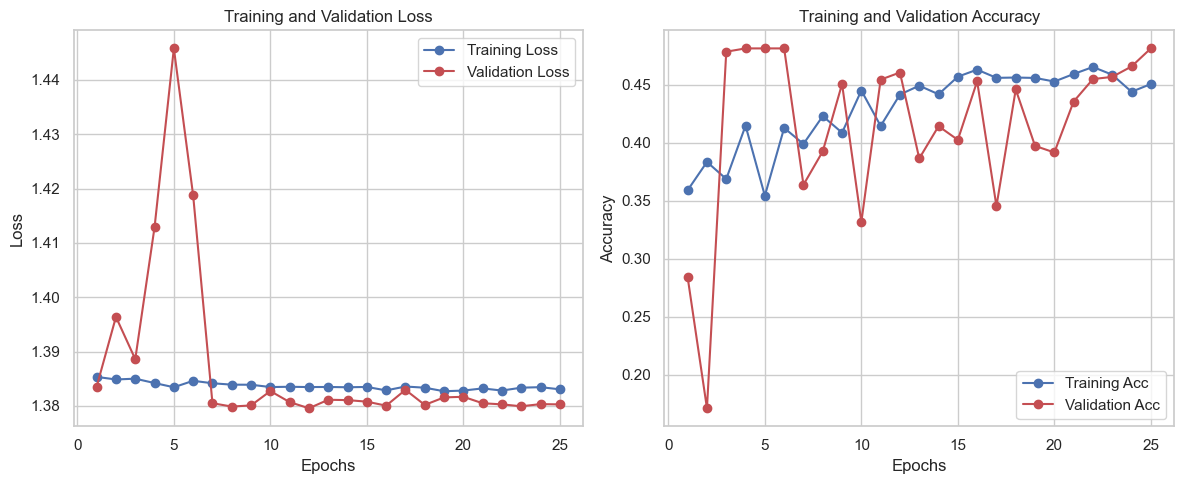

In [66]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

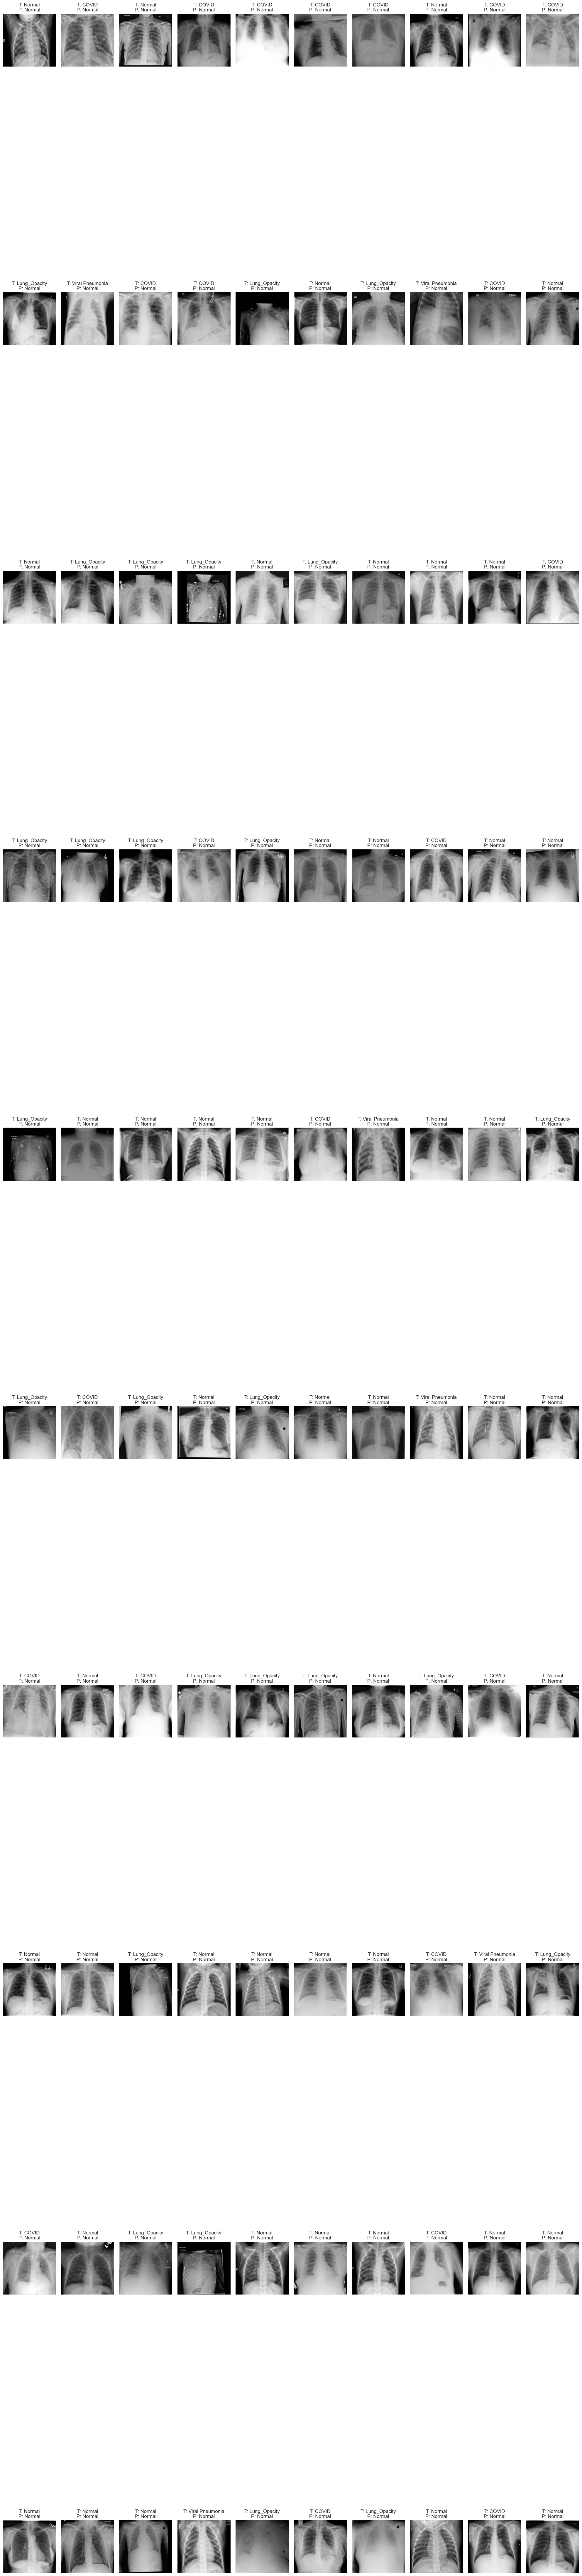

In [67]:
import random

def visualize_random_100_predictions(model, dataloader, classes, num_images=100):
    model.eval()
    collected_images, collected_labels, collected_preds = [], [], []
    
    with torch.no_grad():
        # Loop over the dataset and randomly sample images until we collect 100
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Move tensors to CPU for numpy conversion
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            
            # Select a random subset of images from the batch if needed
            indices = list(range(images.shape[0]))
            random.shuffle(indices)
            for idx in indices:
                if len(collected_images) < num_images:
                    collected_images.append(images[idx])
                    collected_labels.append(labels[idx])
                    collected_preds.append(preds[idx])
                else:
                    break
            if len(collected_images) >= num_images:
                break  # Stop once we have 100 images

    # Plot the 100 random images with true and predicted labels
    plt.figure(figsize=(20, 100))  # Adjust figure size for better viewing
    for i in range(num_images):
        plt.subplot(num_images // 10, 10, i + 1)
        
        # Display the image
        img = collected_images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"T: {classes[collected_labels[i]]}\nP: {classes[collected_preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 100 random sample predictions
visualize_random_100_predictions(trained_model, test_loader, classes, num_images=100)
